# Notatki

 * Jakbyśmy mieli do czynienia z ciagłym przypływem próbek bez żadnych przerw to moglibyśmy pozwolić sobie na dropnięcie czasu
 * Lepiej celować w wielkość typu 200-400 time steps w LSTM(patrz: [źródło](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/))

# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.4


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l data

 Volume in drive D is Data
 Volume Serial Number is 82E7-60C3

 Directory of D:\Studia\Auto_Tag


 Directory of D:\Studia\Auto_Tag\data

09.04.2020  16:52    <DIR>          .
09.04.2020  16:52    <DIR>          ..
09.04.2020  16:52         1˙076˙355 easy.csv
09.04.2020  16:52         2˙924˙235 hard.csv
09.04.2020  16:52         2˙787˙990 medium.csv
               3 File(s)      6˙788˙580 bytes
               2 Dir(s)  195˙887˙439˙872 bytes free


File Not Found


In [4]:
df = pd.read_csv("data//easy.csv")

In [5]:
df.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,Car
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,Car
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,Car


In [6]:
'''
Wygląd danych:

|     Nazwa     | Ilość pól |
| :-----------: | :-------: |
|     time      |     1     |
| accelerometer |     4     |
|   gyroscope   |     4     |
|     sound     |     4     |
|    target     |     1     |

Suma: 14

'''


df.shape

(5893, 14)

# Obróbka danych

In [7]:
'''
Zmiana targetu na liczby:

0 - Still
1 - Car
2 - Train
3 - Bus
4 - Walking
'''
df.target.unique()

array(['Still', 'Car', 'Train', 'Bus', 'Walking'], dtype=object)

In [8]:
df = df.replace({'target':'Still'},{'target':0})
df = df.replace({'target':'Car'},{'target':1})
df = df.replace({'target':'Train'},{'target':2})
df = df.replace({'target':'Bus'},{'target':3})
df = df.replace({'target':'Walking'},{'target':4})

In [9]:
'''
Podział danych z całego df na X i y:

X - wszystko oprócz targetu(time, accelerometer,gyroscope, sound) 
y - target
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [10]:
df.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,0
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,1
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,0
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,1
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,1


# Podział na dane testowe i treningowe

In [11]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(4714)
test  - 20% danych(1179)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

'''
Podział na X_train, y_train, X_test, y_test

X_train, X_test - bez 'targetu'
y_train, y_test - sam 'target' dla X_train, X_test
'''
X_train = train.drop('target', axis = 1)
y_train = train.target

X_test = test.drop('target', axis = 1)
y_test = test.target

In [12]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4713, 13)
	 y_train: (4713,)
	 X_test: (1180, 13)
	 y_test: (1180,)


In [13]:
# Konwersja danych z pandas dataframe do numpy

df = df.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [14]:
# Upewnienie się że dane w X_train i X_test są floatem - lepsze dla klasyfikatora

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [15]:
num_classes = 5

# Zamiana wpisu z [1] na [0, 1, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
# Upewnienie się że dane w y_train i y_test są floatem - lepsze dla klasyfikatora

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [17]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4713, 13)
	 y_train: (4713, 5)
	 X_test: (1180, 13)
	 y_test: (1180, 5)


# Zmiana wymiarowości

In [18]:
'''
LSTM potrzebuje wymiarów w 3D

Input shape:
 - Samples - jedna sekwwncja to sampel
 - Time steps - punkt obserwacji w próbce
 - Features - jedna obserwacja w punkcie
 
X_train to ~4713 próbek, po 1 timestampie w każdej i 13 zmiennych w środku
'''
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4713, 13)
	 y_train: (4713, 5)
	 X_test: (1180, 13)
	 y_test: (1180, 5)


In [19]:
X_train = numpy.expand_dims(X_train, axis=1)
y_train = numpy.expand_dims(y_train, axis=1)

X_test = numpy.expand_dims(X_test, axis=1)
y_test = numpy.expand_dims(y_test, axis=1)

In [20]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (5893, 14)
	 X_train: (4713, 1, 13)
	 y_train: (4713, 1, 5)
	 X_test: (1180, 1, 13)
	 y_test: (1180, 1, 5)


In [21]:
X_train.shape

(4713, 1, 13)

# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=False,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Model

In [27]:
# Stałe do monitorowania pracy modelu

epochs = 50
batch_size = None
validation_steps = 200, #test.shape[0]//batch_size,
steps_per_epoch = 200, #train.shape[0]//batch_size,
optimizer = 'adam'
loss_type = 'categorical_crossentropy'
LSTM_size = 128

In [28]:
model = Sequential()
model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            72704     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 5)              645       
Total params: 73,349
Trainable params: 73,349
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis do nowego pliku
model.save('the_best.h5')

Train on 4713 samples, validate on 1180 samples
Epoch 1/50
4713/4713 [==============================] - 1s 139us/step - loss: 1.3847 - accuracy: 0.4144 - get_f1: 0.0922 - val_loss: 1.2004 - val_accuracy: 0.4992 - val_get_f1: 0.3303

Epoch 00001: val_loss improved from inf to 1.20044, saving model to best.h5
Epoch 2/50
4713/4713 [==============================] - 0s 68us/step - loss: 1.1274 - accuracy: 0.5315 - get_f1: 0.3607 - val_loss: 1.0640 - val_accuracy: 0.5415 - val_get_f1: 0.4065

Epoch 00002: val_loss improved from 1.20044 to 1.06403, saving model to best.h5
Epoch 3/50
4713/4713 [==============================] - 0s 70us/step - loss: 1.0413 - accuracy: 0.5695 - get_f1: 0.4308 - val_loss: 1.0086 - val_accuracy: 0.5864 - val_get_f1: 0.4685

Epoch 00003: val_loss improved from 1.06403 to 1.00862, saving model to best.h5
Epoch 4/50
4713/4713 [==============================] - 0s 68us/step - loss: 1.0140 - accuracy: 0.5769 - get_f1: 0.4596 - val_loss: 1.0275 - val_accuracy: 0.5610 -

4713/4713 [==============================] - 0s 63us/step - loss: 0.7686 - accuracy: 0.6817 - get_f1: 0.6535 - val_loss: 0.7914 - val_accuracy: 0.6924 - val_get_f1: 0.6533

Epoch 00033: val_loss improved from 0.79593 to 0.79141, saving model to best.h5
Epoch 34/50
4713/4713 [==============================] - 0s 64us/step - loss: 0.7604 - accuracy: 0.6898 - get_f1: 0.6658 - val_loss: 0.7937 - val_accuracy: 0.6864 - val_get_f1: 0.6547

Epoch 00034: val_loss did not improve from 0.79141
Epoch 35/50
4713/4713 [==============================] - 0s 63us/step - loss: 0.7620 - accuracy: 0.6834 - get_f1: 0.6548 - val_loss: 0.7965 - val_accuracy: 0.6754 - val_get_f1: 0.6594

Epoch 00035: val_loss did not improve from 0.79141
Epoch 36/50
4713/4713 [==============================] - 0s 63us/step - loss: 0.7498 - accuracy: 0.6917 - get_f1: 0.6708 - val_loss: 0.7910 - val_accuracy: 0.6797 - val_get_f1: 0.6664

Epoch 00036: val_loss improved from 0.79141 to 0.79102, saving model to best.h5
Epoch 37/5

# Statystyki

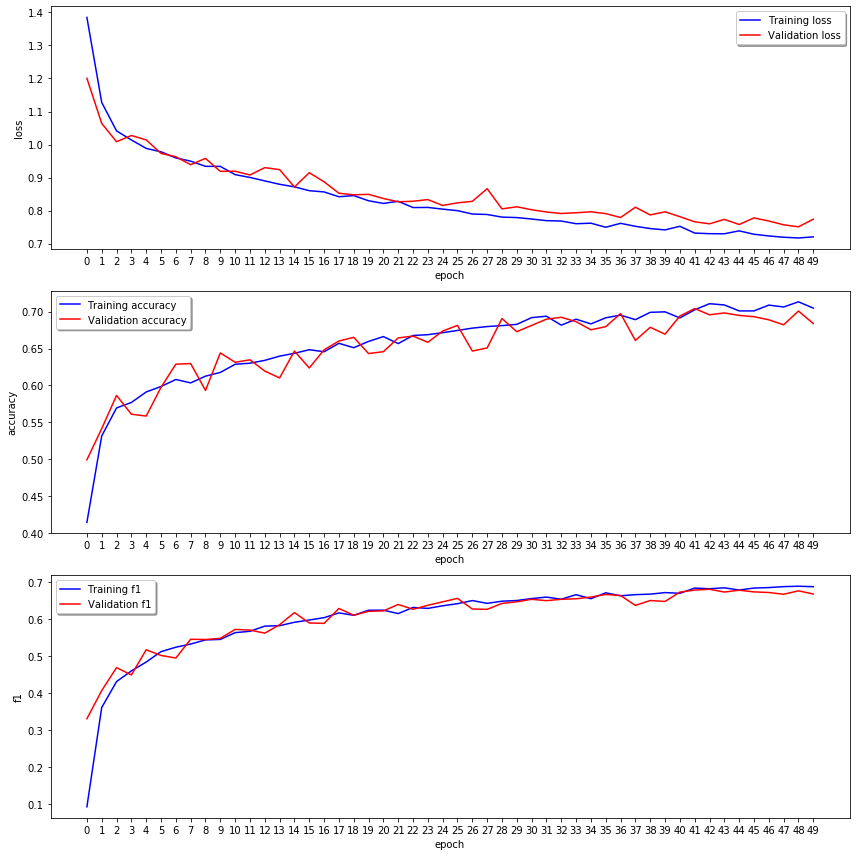

Test loss: 0.751
Test accuracy: 0.701
Test F1: 0.676


In [40]:
loss, accuracy, get_f1  = model.evaluate(X_test, y_test, verbose=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')


In [31]:
predictions = model.predict(X_test)

In [32]:
# Predykcje są zakodowane w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele

predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], predictions)))
predictions = numpy.reshape(predictions, (y_test.shape[0],))

y_pred = predictions

In [34]:
# Etykieta target jest zakodowana w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele
tmp = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], y_test)))
tmp = numpy.reshape(tmp, (y_test.shape[0],))

y_true = tmp

In [35]:
cm = confusion_matrix(y_true, y_pred)

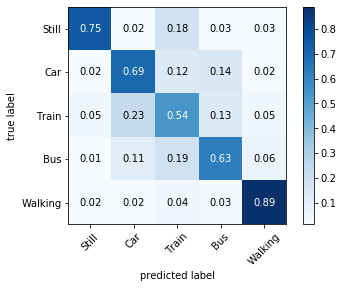

In [36]:
plot_cm(cm, ['Still', 'Car', 'Train', 'Bus', 'Walking'])

In [37]:
print(cm)

[[177   4  43   6   6]
 [  4 164  29  34   5]
 [ 11  55 128  31  11]
 [  3  26  44 148  15]
 [  5   4  10   7 210]]


In [39]:
accuracy, precision, recall, fscore = countStats(y_true, y_pred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.7008474576271186
Precision: 0.7084456075068999
Recall: 0.7008474576271186
F-score: 0.7030780178794276
